# Approaching Out of Stock (AOOS) Priority Score

### For understanding / testing / modifying the business logic of priority score calculation

* Does not connect to InfoHub for data - uses local CSV files

## Business Logic

* Work item in AOOS work queue is essentially an **inventory**, which is _approaching_ out of stock
* The priority of a work item (inventory) can be estimated based on (_inventory_ - _threshold_)
* We can extend the above logic to estimate how much will be the inventory in the near future (instead of current inventory)
* This is achieved by taking into account supply plans and demand plans and calculating the inventory over an _inventory horizon_, say next 30 days
* **Penalty** is a numerical value denoting the deviation of inventory from the desired threshold
    * Related parameters: `inv_positive_threshold`, `inv_negative_threshold`
* **Weight** is a numerical function defined over the horizon that captures the weightage of penalty
    * Useful to capture varying weight like penalty for next few days carries more weight than the penalty for the 25th day
    * Related parameter: `decay_weight`

In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt

## Config Parameters

* Horizon of interest: \[`first_date`, `last_date`\]
    * Current inventory is on the `first_date` 
    * For production, `first_date` would be today's date
* `inv_positive_threshold`: (>= 0) Positive threshold, below which penalty is applicable
    * Default value can be 0, indicating that only _out of stock_ is penalized
    * If it is 10, then any value below 10 is also penalized - useful for penalizing _approaching out of stock_
* `inv_negative_threshold`: (< 0) Maximum negative inventory for calculating penalty
    * If it is -100, then any inventory < -100 is treated as -100
    * This ensures a bound on the max penalty to restrict the score to be in range \[0, 100\]
* `decay_weight`: \[1.0, 2.0, ...\] 
    * Exponential decay function captures the weightage of penalty over the horizon - near future carries more weight
    * `decay_weight` defines the shape of the normalized weight function
    * Default value is `3.0`, check below for shapes of different weights

### Experiments

* **Parameters**
    * Change the parameter values and compare results to analyze and determine appropriate parameter values for an inventory (based on quantity, frequency of supply / demand plans, etc)
* **Input Data**
    * Supply and demand plan data are pre-loaded in the folder `data`
    * Change the quantity and / or date in the CSV files to analyze / modify the business logic

In [2]:
first_date = datetime.date(2021, 7, 31)
last_date = datetime.date(2021, 8, 31)
horizon = (last_date - first_date).days + 1
decay_weight = 3.0
inv_positive_threshold = 100
inv_negative_threshold = -300
horizon_days = np.arange(1, horizon+1, 1)

In [3]:
# I/O Folders
data_folder = "data/"
figs_folder = "figs/"

### Inventory / Work Item

* Inventory is uniquely identified by `partNumber` and `locationIdentifier`
* Choose one of the following two inventories to experiment
    * Associated input CSV files are in the `data` folder

In [4]:
# Inventory / Work Item 1
partNumber = "CO-RD-R296"
locationIdentifier = "LT-2"
starting_inventory = 80

In [ ]:
# Inventory / Work Item 2
# partNumber = "CO-RD-S282"
# locationIdentifier = "LT-2"
# starting_inventory = 40

In [5]:
supply_file = "-".join(["supply-plans", partNumber, locationIdentifier])+".csv"
demand_file = "-".join(["demand-plans", partNumber, locationIdentifier])+".csv"

## Input
* Read `supply_plans` and `demand_plans` from `data` folder
* `starting_inventory`: Inventory on the `first_date`

In [6]:
supply_plans = pd.read_csv(os.path.join(data_folder, supply_file))
demand_plans = pd.read_csv(os.path.join(data_folder, demand_file))

In [7]:
demand_plans

,demandPlanId,startDate,quantity
0,5dffd325-ef18-48d6-9f51-a112a8abb98f,2021-08-01T00:00:00.000Z,35.0
1,a2254a49-27eb-4ef2-947a-791570c1c4f4,2021-08-02T00:00:00.000Z,50.0
2,dbc2fcc5-be18-4827-b863-59f1496202c6,2021-08-03T00:00:00.000Z,35.0
3,4dd04bfa-fc8a-4d81-8be9-3aa176b1e87c,2021-08-04T00:00:00.000Z,50.0
4,00d39be7-5551-49ff-96c1-32a0ef9ea2b8,2021-08-05T00:00:00.000Z,35.0
5,de4f9ee7-a486-43da-98f0-9c3db2147008,2021-08-06T00:00:00.000Z,50.0
6,6219f53e-eda5-4a5e-acc9-69432863b916,2021-08-07T00:00:00.000Z,35.0
7,efa3928a-700b-47c6-81cf-a621afc0732a,2021-08-08T00:00:00.000Z,50.0
8,4801ca4a-d9d6-411c-a934-45bafe5a4688,2021-08-09T00:00:00.000Z,35.0
9,dc4e0c0b-6581-42d1-b2b5-409aa7dc12bb,2021-08-10T00:00:00.000Z,50.0


In [8]:
supply_plans

,supplyPlanId,startDate,quantity
0,6190b1df-0444-491f-b2e2-7fd50b27397c,2021-08-07T00:00:00.000Z,150.0
1,e4cf0d00-948d-4e78-b204-8e3700c8a61d,2021-08-17T00:00:00.000Z,350.0
2,f0cd9eee-0749-482a-a269-aa089f84e461,2021-08-27T00:00:00.000Z,350.0


In [9]:
horizon_days = np.arange(1, horizon+1, 1)

In [10]:
# Define Inventory horizon and add starting inventory
inventory_horizon = np.zeros(horizon, dtype=int)
inventory_horizon = inventory_horizon + starting_inventory
inventory_horizon

array([80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80])

In [11]:
# Add Supply plans
supply = np.zeros(horizon, dtype=int)
for i in range(len(supply_plans)):
    supply_date = datetime.datetime.fromisoformat(supply_plans.loc[i, 'startDate'][:-1]).date()
    qty = supply_plans.loc[i, 'quantity']
    diff_days = (supply_date - first_date).days
    inventory_horizon[diff_days:] = inventory_horizon[diff_days:] + qty
    supply[diff_days] = qty
inventory_horizon

array([ 80,  80,  80,  80,  80,  80,  80, 230, 230, 230, 230, 230, 230,
       230, 230, 230, 230, 580, 580, 580, 580, 580, 580, 580, 580, 580,
       580, 930, 930, 930, 930, 930])

Text(0, 0.5, 'Supply')

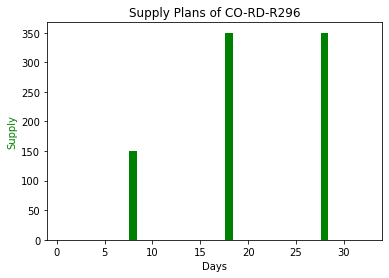

In [12]:
fig,ax=plt.subplots()
ax.bar(horizon_days, supply, color="green")
ax.set_title("Supply Plans of {}".format(partNumber))
ax.set_xlabel("Days")
ax.set_ylabel("Supply", color="green")

In [13]:
# Modify the filename as required to save in the figs folder
filename = "-".join(["supply-plans", partNumber, locationIdentifier])+".jpg"

In [14]:
fig.savefig(os.path.join(figs_folder, filename),
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

In [15]:
# Add Demand plans
demand = np.zeros(horizon, dtype=int)
for i in range(len(demand_plans)):
    demand_date = datetime.datetime.fromisoformat(demand_plans.loc[i, 'startDate'][:-1]).date()
    qty = demand_plans.loc[i, 'quantity']
    diff_days = (demand_date - first_date).days
    inventory_horizon[diff_days:] = inventory_horizon[diff_days:] - qty
    demand[diff_days] = qty
inventory_horizon

array([  80,   45,   -5,  -40,  -90, -125, -175,  -60, -110, -145, -195,
       -280, -315, -365, -400, -450, -485, -185, -220, -270, -305, -355,
       -390, -440, -475, -525, -560, -245, -280, -315, -350, -350])

Text(0, 0.5, 'Demand')

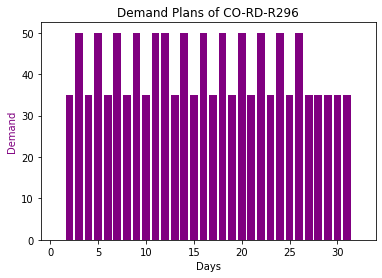

In [16]:
fig,ax=plt.subplots()
ax.bar(horizon_days, demand, color="purple")
ax.set_title("Demand Plans of {}".format(partNumber))
ax.set_xlabel("Days")
ax.set_ylabel("Demand", color="purple")

In [17]:
filename = "-".join(["demand-plans", partNumber, locationIdentifier])+".jpg"

In [18]:
fig.savefig(os.path.join(figs_folder, filename),
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

In [19]:
# Calculate weights
weights = np.exp(np.arange(decay_weight, 0, -(decay_weight/horizon)))/np.exp(decay_weight)

In [20]:
# Calculate penalty
inventory_below_threshold = inventory_horizon - inv_positive_threshold
penalties = np.zeros(horizon, dtype=int)
neg_inv_mask = inventory_below_threshold < 0
penalties[neg_inv_mask] = inventory_below_threshold[neg_inv_mask] 

In [21]:
neg_threshold_mask = penalties < inv_negative_threshold
penalties[neg_threshold_mask] = inv_negative_threshold
penalties

array([ -20,  -55, -105, -140, -190, -225, -275, -160, -210, -245, -295,
       -300, -300, -300, -300, -300, -300, -285, -300, -300, -300, -300,
       -300, -300, -300, -300, -300, -300, -300, -300, -300, -300])

Text(0, 0.5, 'Inventory')

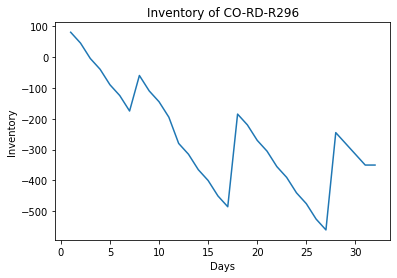

In [22]:
fig,ax=plt.subplots()
ax.plot(horizon_days, inventory_horizon)
ax.set_title("Inventory of {}".format(partNumber))
ax.set_xlabel("Days")
ax.set_ylabel("Inventory")

In [23]:
filename = "-".join(["new-inventory", partNumber, locationIdentifier])+".jpg"

In [24]:
fig.savefig(os.path.join(figs_folder, filename),
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

Text(0, 0.5, 'Weight')

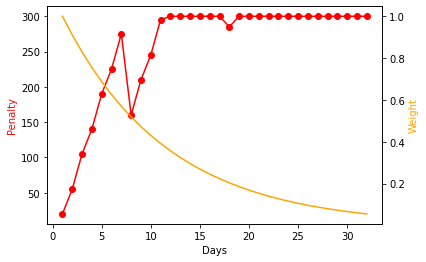

In [25]:
fig,ax=plt.subplots()
ax.plot(horizon_days, -penalties, marker="o", color="red")
ax.set_xlabel("Days")
ax.set_ylabel("Penalty", color="red")
ax2=ax.twinx()
ax2.plot(horizon_days, weights, color="orange")
ax2.set_ylabel("Weight", color="orange")

In [26]:
filename = "-".join(["new-penalty", partNumber, locationIdentifier])+".jpg"

In [27]:
fig.savefig(os.path.join(figs_folder, filename),
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

In [28]:
total_penalty = np.sum(weights*-penalties)
total_penalty

2119.345110309453

### Normalize

* Priority score is normalized using the term `max_penalty` to be in range 0 - 100
    * Normalized is useful for comparing different work items / inventories

In [29]:
max_penalty = np.sum(weights*-inv_negative_threshold)
max_penalty

3185.440056364701

In [30]:
priority_score = np.rint((total_penalty/max_penalty)*100)
priority_score

67.0

### Testing decay weights

In [31]:
horizon = 31

In [32]:
horizon_days = np.arange(1, horizon+1, 1)
decay1 = np.exp(np.arange(1, 0, -(1.0/horizon)))/np.exp(1)
decay2 = np.exp(np.arange(2, 0, -(2.0/horizon)))/np.exp(2)
decay3 = np.exp(np.arange(3, 0, -(3.0/horizon)))/np.exp(3)
decay4 = np.exp(np.arange(4, 0, -(4.0/horizon)))/np.exp(4)

Text(0.5, 1.0, 'Weights Decay')

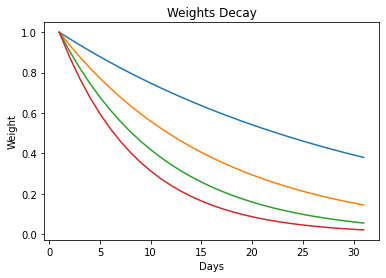

In [33]:
fig,ax=plt.subplots()
ax.plot(horizon_days, decay1, horizon_days, decay2, horizon_days, decay3, horizon_days, decay4)
ax.set_xlabel("Days")
ax.set_ylabel("Weight")
ax.set_title("Weights Decay")

In [ ]:
fig.savefig(os.path.join(figs_folder, "weights-decay.jpg"),
            format='jpeg',
            dpi=100,
            bbox_inches='tight')